
# Noisy Quantum Simulation with Qiskit Aer  
**Depolarizing & Amplitude-Damping Noise — with density matrices, fidelity, purity, and Bloch vectors**

This notebook showcases:
- A robust `NoiseExtractor` that runs Qiskit Aer **density-matrix** simulations and returns `numpy.complex128` arrays.
- Configurable **single-qubit** noise: depolarizing *or* amplitude-damping.
- **Two-qubit** depolarizing noise for CX/CZ/SWAP.
- Single- and two-qubit examples with visualizations and metrics.
- (Optional) End-to-end comparison via your `NoisyMLSimulator` if present.

> Tip: Run each cell top-to-bottom. If Qiskit or Aer are missing, use the install cell below.


In [1]:
# If needed, uncomment to install dependencies in your environment
!pip install -U qiskit qiskit-aer numpy matplotlib


In [2]:

import numpy as np
import matplotlib.pyplot as plt

# Try to import Qiskit and your NoiseExtractor
try:
    from qiskit import QuantumCircuit
    try:
        import qiskit_aer  # Aer meta-package
        from qiskit_aer import AerSimulator
    except Exception:
        # Aer might be available under providers in some installs; NoiseExtractor handles both.
        from qiskit.providers.aer import AerSimulator  # type: ignore
    AER_OK = True
except Exception as e:
    AER_OK = False
    print("Qiskit/Aer not available. Please install qiskit and qiskit-aer to continue.")
    raise

# Import the provided NoiseExtractor (from your project)
try:
    from qiskit_noise_extractor import NoiseExtractor
except Exception as e:
    print("Could not import noise_models.qiskit_noise_extractor.NoiseExtractor. "
          "Ensure your project is on PYTHONPATH or run this notebook from the repo root.")
    raise

print("Environment OK — Qiskit and NoiseExtractor are available.")


Environment OK — Qiskit and NoiseExtractor are available.


In [3]:

def is_density_matrix(rho: np.ndarray, tol: float = 1e-6) -> bool:
    if not isinstance(rho, np.ndarray) or rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        return False
    if not np.allclose(rho, rho.conjugate().T, atol=tol):
        return False
    if not np.allclose(np.trace(rho), 1.0, atol=tol):
        return False
    return True

def pure_state_density(psi: np.ndarray) -> np.ndarray:
    return np.outer(psi, psi.conjugate()).astype(np.complex128)

def fidelity_pure(psi: np.ndarray, rho: np.ndarray) -> float:
    return float(np.real(np.vdot(psi, rho.dot(psi))))

def purity(rho: np.ndarray) -> float:
    return float(np.real(np.trace(rho.dot(rho))))

def reduced_density(rho: np.ndarray, n_qubits: int, keep: int) -> np.ndarray:
    # Partial trace over all but qubit `keep`
    rho_t = rho.reshape([2] * (2 * n_qubits))
    # permutation to bring keep qubit to leading axes
    rows = list(range(0, n_qubits))
    cols = list(range(n_qubits, 2 * n_qubits))
    keep_row = keep
    keep_col = keep + n_qubits
    other_rows = [r for r in rows if r != keep_row]
    other_cols = [c for c in cols if c != keep_col]
    perm = [keep_row, keep_col] + other_rows + other_cols
    rho_perm = np.transpose(rho_t, perm)
    k = n_qubits - 1
    rho_perm = rho_perm.reshape(2, 2, 2 ** k, 2 ** k)
    reduced = np.zeros((2, 2), dtype=rho.dtype)
    for i in range(2 ** k):
        reduced += rho_perm[:, :, i, i]
    return reduced

def bloch_from_density_1q(rho_1q: np.ndarray) -> np.ndarray:
    rho00 = rho_1q[0, 0]
    rho11 = rho_1q[1, 1]
    rho01 = rho_1q[0, 1]
    rx = 2.0 * np.real(rho01)
    ry = -2.0 * np.imag(rho01)
    rz = np.real(rho00 - rho11)
    return np.array([rx, ry, rz], dtype=float)

def show_density_heatmaps(rho: np.ndarray, title_prefix: str = "ρ"):
    """Two heatmaps: |ρ| and angle(ρ) in radians."""
    fig1 = plt.figure(figsize=(5,4))
    plt.imshow(np.abs(rho))
    plt.title(f"{title_prefix}: magnitude |ρ|")
    plt.xlabel("col"); plt.ylabel("row")
    plt.colorbar()
    plt.show()

    fig2 = plt.figure(figsize=(5,4))
    plt.imshow(np.angle(rho))
    plt.title(f"{title_prefix}: phase arg(ρ)")
    plt.xlabel("col"); plt.ylabel("row")
    plt.colorbar()
    plt.show()

def simulate_ideal_density(qc):
    """Simulate ideal circuit (no noise) using statevector method and return ρ = |ψ⟩⟨ψ|."""
    sim = AerSimulator(method="statevector")
    qc_run = qc.copy()
    try:
        qc_run.save_statevector()
    except Exception:
        try:
            qc_run.save_state()
        except Exception:
            pass
    result = sim.run(qc_run).result()
    data = result.data()
    if "statevector" in data:
        sv = data["statevector"]
    else:
        # last-resort extract
        sv = result.get_statevector() if hasattr(result, "get_statevector") else None
    psi = np.asarray(getattr(sv, "data", sv), dtype=np.complex128)
    return pure_state_density(psi)



## 1) Single-qubit: Hadamard with depolarizing noise
We apply an H gate to \|0⟩, then simulate with depolarizing noise on single-qubit gates.


Fidelity(|+>, ρ_noisy): 0.975
Purity(ρ_ideal): 1.0   Purity(ρ_noisy): 0.9512500000000002
Bloch (ideal): [ 1.00000000e+00 -0.00000000e+00  2.22044605e-16]
Bloch (noisy): [ 9.50000000e-01 -0.00000000e+00  1.66533454e-16]


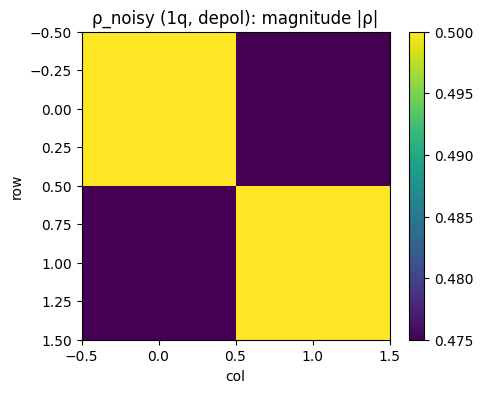

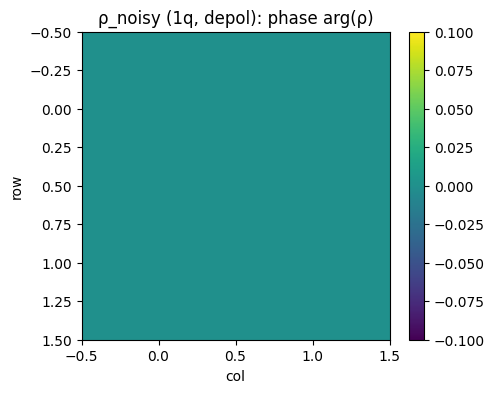

In [4]:

# Build the circuit
qc_1q = QuantumCircuit(1)
qc_1q.h(0)

# Ideal density
rho_ideal_1q = simulate_ideal_density(qc_1q)

# Noisy depolarizing on 1q gates
ne_depol = NoiseExtractor(p_1qubit=0.05, p_2qubit=0.0, error_kind="depolarizing")
rho_noisy_1q = ne_depol.simulate_circuit(qc_1q)

assert is_density_matrix(rho_noisy_1q), "Noisy output is not a valid density matrix."

# Metrics
psi_plus = np.array([1.0, 1.0], dtype=np.complex128) / np.sqrt(2)
fid_1q = fidelity_pure(psi_plus, rho_noisy_1q)
pur_ideal_1q = purity(rho_ideal_1q)
pur_noisy_1q = purity(rho_noisy_1q)

print("Fidelity(|+>, ρ_noisy):", fid_1q)
print("Purity(ρ_ideal):", pur_ideal_1q, "  Purity(ρ_noisy):", pur_noisy_1q)

# Bloch vectors
bloch_ideal = bloch_from_density_1q(rho_ideal_1q)
bloch_noisy = bloch_from_density_1q(rho_noisy_1q)
print("Bloch (ideal):", bloch_ideal)
print("Bloch (noisy):", bloch_noisy)

# Visualize
show_density_heatmaps(rho_noisy_1q, title_prefix="ρ_noisy (1q, depol)")



## 2) Two-qubit: H on q0 then CX with amplitude damping on 1q gates and depolarizing on 2q gates
We set amplitude-damping probability on single-qubit gates and depolarizing on CX.


Fidelity(|ψ_ideal>, ρ_noisy): 0.2737499999999999
Purity(ρ_ideal): 1.0   Purity(ρ_noisy): 0.8862624999999993
Bloch q0 (ideal): [ 0.00000000e+00 -0.00000000e+00  2.22044605e-16]
Bloch q0 (noisy): [ 0.    -0.     0.095]


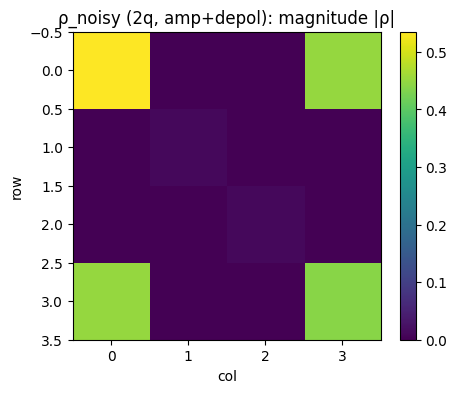

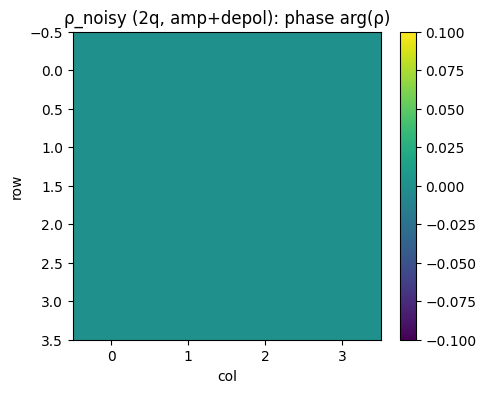

In [7]:

# Build the circuit: |0>--H--*--
#                           |  |
#                          |0> X
qc_2q = QuantumCircuit(2)
qc_2q.h(0)
qc_2q.cx(0, 1)

# Ideal density
rho_ideal_2q = simulate_ideal_density(qc_2q)

# Noisy: amplitude damping for 1q, depolarizing for 2q
ne_amp = NoiseExtractor(p_1qubit=0.0, p_2qubit=0.05, error_kind="amplitude_damping", p_amp=0.1)
rho_noisy_2q = ne_amp.simulate_circuit(qc_2q)

# Ideal |ψ> for this circuit: (|00> + |10>)/√2
psi_plus0 = np.array([1.0, 1.0], dtype=np.complex128) / np.sqrt(2)
psi_ideal_2q = np.kron(psi_plus0, np.array([1.0, 0.0], dtype=np.complex128))

fid_2q = fidelity_pure(psi_ideal_2q, rho_noisy_2q)
pur_ideal_2q = purity(rho_ideal_2q)
pur_noisy_2q = purity(rho_noisy_2q)

print("Fidelity(|ψ_ideal>, ρ_noisy):", fid_2q)
print("Purity(ρ_ideal):", pur_ideal_2q, "  Purity(ρ_noisy):", pur_noisy_2q)

# Reduced single-qubit states & Bloch vectors (qubit 0)
rho0_ideal = reduced_density(rho_ideal_2q, n_qubits=2, keep=0)
rho0_noisy = reduced_density(rho_noisy_2q, n_qubits=2, keep=0)
bloch0_ideal = bloch_from_density_1q(rho0_ideal)
bloch0_noisy = bloch_from_density_1q(rho0_noisy)
print("Bloch q0 (ideal):", bloch0_ideal)
print("Bloch q0 (noisy):", bloch0_noisy)

# Visualize
show_density_heatmaps(rho_noisy_2q, title_prefix="ρ_noisy (2q, amp+depol)")


=== amplitude_damping ===
params: {'p_1qubit': 0.0, 'p_2qubit': 0.05, 'p_amp': 0.1}
Fidelity(|ψ_ideal>, ρ_noisy) = 0.273750
Purity(ρ_noisy) = 0.886262
Bloch (qubit 0) = [0.0000, -0.0000, 0.0950]


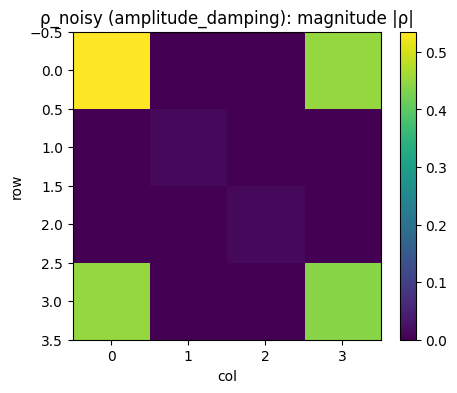

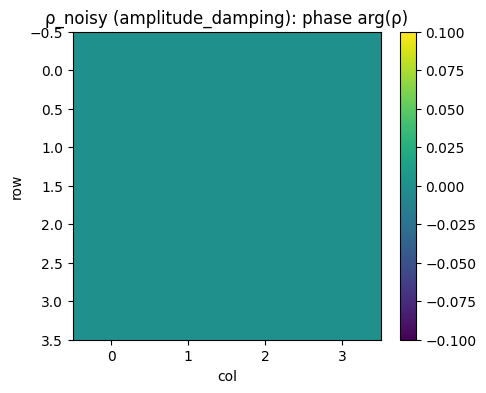

=== phase_damping ===
params: {'p_1qubit': 0.0, 'p_2qubit': 0.05, 'p_phase': 0.2}
Fidelity(|ψ_ideal>, ρ_noisy) = 0.250000
Purity(ρ_noisy) = 0.836625
Bloch (qubit 0) = [0.0000, -0.0000, 0.0000]


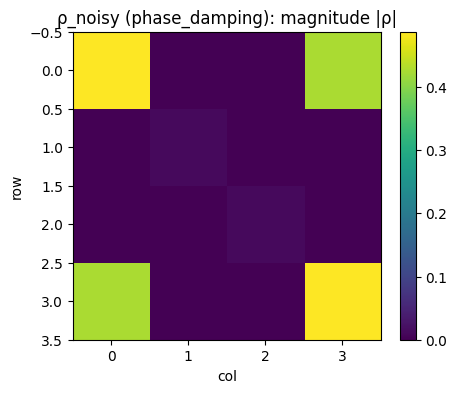

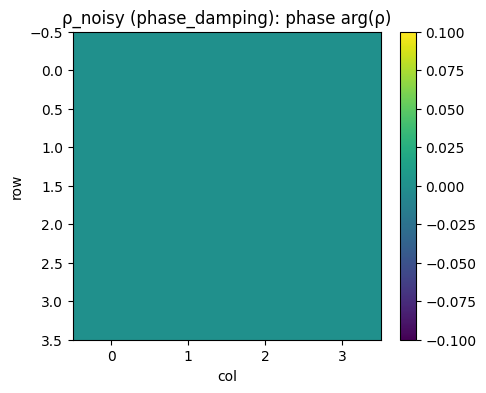

=== depolarizing ===
params: {'p_1qubit': 0.08, 'p_2qubit': 0.05}
Fidelity(|ψ_ideal>, ρ_noisy) = 0.250000
Purity(ρ_noisy) = 0.857563
Bloch (qubit 0) = [0.0000, -0.0000, 0.0000]


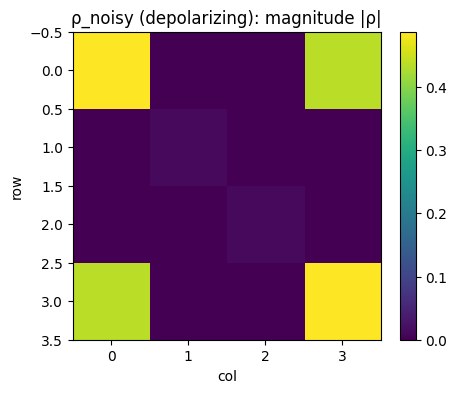

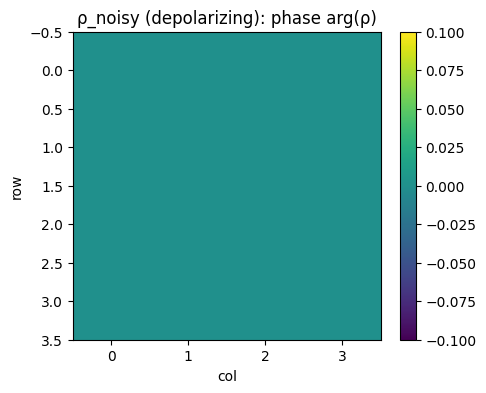

In [19]:

# --- build the 2-qubit circuit ---
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

rho_ideal = simulate_ideal_density(qc)
psi_plus0 = np.array([1.0, 1.0], dtype=np.complex128) / np.sqrt(2)
psi_ideal = np.kron(psi_plus0, np.array([1.0, 0.0], dtype=np.complex128))

scenarios = [
    ("amplitude_damping", dict(p_1qubit=0.0, p_2qubit=0.05, p_amp=0.1)),
    ("phase_damping",     dict(p_1qubit=0.0, p_2qubit=0.05, p_phase=0.2)),
    ("depolarizing",      dict(p_1qubit=0.08, p_2qubit=0.05)),
]

for kind, params in scenarios:
    ne = NoiseExtractor(error_kind=kind, **params)
    rho_noisy = ne.simulate_circuit(qc)

    assert is_density_matrix(rho_noisy), f"result not a density matrix for {kind}"

    fid = fidelity_pure(psi_ideal, rho_noisy)
    pur = purity(rho_noisy)

    rho0 = reduced_density(rho_noisy, n_qubits=2, keep=0)
    bloch0 = bloch_from_density_1q(rho0)

    print(f"=== {kind} ===")
    print("params:", params)
    print(f"Fidelity(|ψ_ideal>, ρ_noisy) = {fid:.6f}")
    print(f"Purity(ρ_noisy) = {pur:.6f}")
    print(f"Bloch (qubit 0) = [{bloch0[0]:.4f}, {bloch0[1]:.4f}, {bloch0[2]:.4f}]")

    show_density_heatmaps(rho_noisy, title_prefix=f"ρ_noisy ({kind})")
